<a href="https://colab.research.google.com/github/hansbrunner/clinical_trials-analysis/blob/main/cdisc_pilot_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Analysis of the cdisc sdtm pilot data set
I look at recruitment across sites, number of patients by visits, efficacy from 2 tests and reported adverse events
I played a little with the data, to get an understanding of cdisc sdtm data format. However, the adam format is more appropriate for data analysis
"""

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [225]:
# Read xpt files
import os
import pandas as pd

# path to folder
folder_path = '/content/drive/MyDrive/Clinical data analysis/cdisc/cdiscpilot01'

# List with all .xpt files in folder path
xpt_files = [f for f in os.listdir(folder_path) if f.endswith('.xpt')]

# Load .xpt files into a dictionary of dataframes
data_dict = {}

for xpt_file in xpt_files:
    file_path = os.path.join(folder_path, xpt_file)
    data_dict[xpt_file] = pd.read_sas(file_path, format='xport')

# Display the keys (file names) in the dictionary
print(data_dict.keys())


dict_keys(['ae.xpt', 'cm.xpt', 'suppae.xpt', 'ex.xpt', 'suppdm.xpt', 'se.xpt', 'dm.xpt', 'lb.xpt', 'sc.xpt', 'qs.xpt', 'relrec.xpt', 'mh.xpt', 'ds.xpt', 'ta.xpt', 'ts.xpt', 'tv.xpt', 'ti.xpt', 'suppds.xpt', 'supplb.xpt', 'sv.xpt', 'te.xpt', 'vs.xpt'])


In [17]:
%pip install graphviz


In [226]:
import numpy as np

def summarize_trial_data_by_group(demographic, disposition, treatment_group):

    if treatment_group not in demographic['ARMCD'].unique():
        raise ValueError(f"The treatment group {treatment_group} is not found in the 'ARMCD' column of the demographics data.")


    # Allocated: Participants who were allocated to the specific treatment group ('ARMCD')
    allocated = np.sum(demographic['ARMCD'] == treatment_group)

    # Actual: Participants who actually received the treatment ('ACTARMCD')
    actual = np.sum(demographic['ACTARMCD'] == treatment_group)

    # Merge disposition with demographic to link treatment ('ARMCD') and  completion ('DSDECOD')
    merged_data = pd.merge(disposition[['USUBJID', 'DSDECOD']], demographic[['USUBJID', 'ARMCD']], on='USUBJID', how='left')

    # Completed: Participants who completed the study
    completed = np.sum((merged_data['ARMCD'] == treatment_group) & (merged_data['DSDECOD'] == b'COMPLETED'))

    # Not Completed
    not_completed = allocated - completed

    # Not Completed: Reasons for non-completion (Lost to follow-up, Withdrawal, Adverse event)
    def count_non_completion(treatment_group, reason):
        return np.sum((merged_data['ARMCD'] == treatment_group) & (merged_data['DSDECOD'] == reason))

    lost_to_follow_up = count_non_completion(treatment_group, b'LOST TO FOLLOW-UP')
    withdrawal_by_subject = count_non_completion(treatment_group, b'WITHDRAWAL BY SUBJECT')
    adverse_event = count_non_completion(treatment_group, b'ADVERSE EVENT')
    other = not_completed - lost_to_follow_up - withdrawal_by_subject - adverse_event

    # Return a dictionary of the results
    return {
        'Allocated': allocated,
        'Actual': actual,
        'Completed': completed,
        'Not_Completed': not_completed,
        'Lost_to_follow_up': lost_to_follow_up,
        'Withdrawal_by_subject': withdrawal_by_subject,
        'Adverse_event': adverse_event,
        'Other': other
    }

In [227]:
# Get data for flow diagram
dm_data = data_dict['dm.xpt']
ds_data = data_dict['ds.xpt']

# Data for low dose Xanomeline
xan_low = summarize_trial_data_by_group(dm_data, ds_data, b'Xan_Lo')

# Data for high dose Xanomeline
xan_high = summarize_trial_data_by_group(dm_data, ds_data, b'Xan_Hi')

# Data for placebo
placebo = summarize_trial_data_by_group(dm_data, ds_data, b'Pbo')

# Assessed for eligibility
scrn = dm_data.shape[0]
# Excluded, planned arm: screening failed
scrnfail = np.sum(dm_data['ARMCD'] == b'Scrnfail')



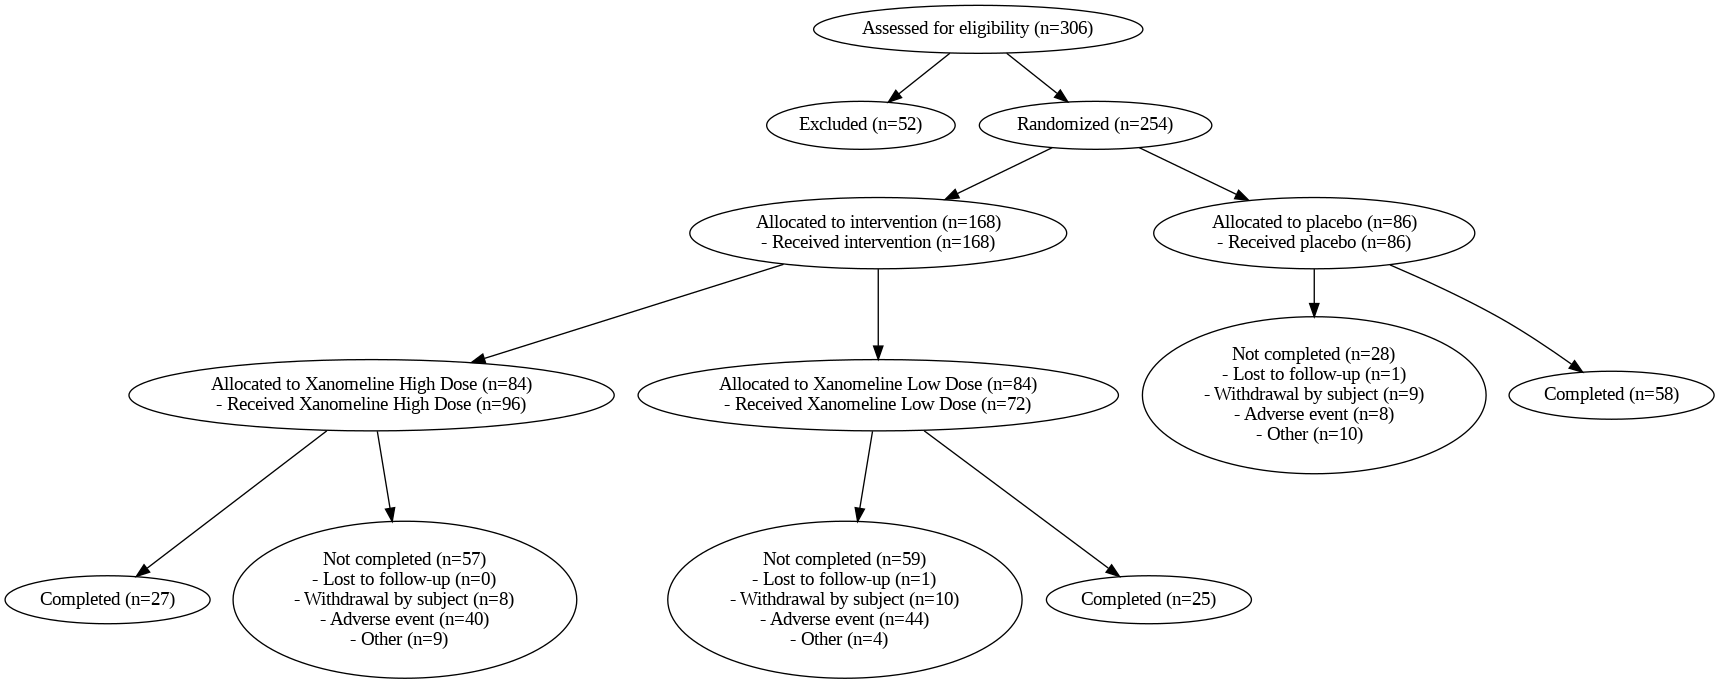

In [228]:
# CONSORT flow diagram
import graphviz

# Create a new directed graph
flowchart = graphviz.Digraph(format='png')

# Add nodes to the flowchart
flowchart.node('A', f"Assessed for eligibility (n={scrn})")
flowchart.node('B', f"Excluded (n={scrnfail})")
flowchart.node('C', f"Randomized (n={scrn-scrnfail})")
flowchart.node('D', f"Allocated to intervention (n={xan_high['Allocated']+xan_low['Allocated']})\n- Received intervention (n={xan_high['Actual']+xan_low['Actual']})")

# High Xanomeline
flowchart.node('E',f"Allocated to Xanomeline High Dose (n={xan_low['Allocated']})\n- Received Xanomeline High Dose (n={xan_low['Actual']})")
flowchart.node('F', f"Completed (n={xan_high['Completed']})")
flowchart.node('G', f"Not completed (n={xan_high['Not_Completed']})\n- Lost to follow-up (n={xan_high['Lost_to_follow_up']})\n- Withdrawal by subject (n={xan_high['Withdrawal_by_subject']})\n- Adverse event (n={xan_high['Adverse_event']})\n- Other (n={xan_high['Other']})  ")

# Low Xanomeline
flowchart.node('H',f"Allocated to Xanomeline Low Dose (n={xan_high['Allocated']})\n- Received Xanomeline Low Dose (n={xan_high['Actual']})")
flowchart.node('I', f"Not completed (n={xan_low['Not_Completed']})\n- Lost to follow-up (n={xan_low['Lost_to_follow_up']})\n- Withdrawal by subject (n={xan_low['Withdrawal_by_subject']})\n- Adverse event (n={xan_low['Adverse_event']})\n- Other (n={xan_low['Other']})  ")
flowchart.node('J', f"Completed (n={xan_low['Completed']})")

#Placebo
flowchart.node('K', f"Allocated to placebo (n={placebo['Allocated']})\n- Received placebo (n={placebo['Actual']})")
flowchart.node('L', f"Not completed (n={placebo['Not_Completed']})\n- Lost to follow-up (n={placebo['Lost_to_follow_up']})\n- Withdrawal by subject (n={placebo['Withdrawal_by_subject']})\n- Adverse event (n={placebo['Adverse_event']})\n- Other (n={placebo['Other']})  ")
flowchart.node('M', f"Completed (n={placebo['Completed']})")


# Add edges to connect the nodes
flowchart.edge('A', 'B') # Eligible and excluded
flowchart.edge('A', 'C') # Eligible and ranomized
flowchart.edge('C', 'D') # Randomized to treatment
flowchart.edge('C', 'K') # Randomized to placebo
flowchart.edge('D', 'E') # Allocated to High Xanomeline
flowchart.edge('D', 'H') # Allocated to Low Xanomeline
flowchart.edge('E', 'F') # Completed High Xanomeline
flowchart.edge('E', 'G') # Not completed High Xanomeline
flowchart.edge('H', 'J') # Completed Low Xanomeline
flowchart.edge('H', 'I') # Not completed Low Xanomeline
flowchart.edge('K', 'M') # Completed placebo
flowchart.edge('K', 'L') # Not completed placebo

# Render the flowchart
flowchart.render('flowchart')

from IPython.display import Image
Image(filename='flowchart.png')


In [229]:
# Table of key characteristics in the different treatment groups (placebo, low, high xanomeline and overall)

def summarize_group(demographics, treatment_group=None):

    # Filter data by treatment group if specified
    if treatment_group:
        group_data = dm_data[dm_data['ARMCD'] == treatment_group]
    else:
        # For the overall summary, exclude 'Scrnfail'
        group_data = dm_data[dm_data['ARMCD'] != b'Scrnfail']

    # Summary statistics for continuous variables (mean ± SD)
    age_mean = group_data['AGE'].mean()
    age_sd = group_data['AGE'].std()

    # Counts for categorical variables (Gender, Race)
    male_count = np.sum(group_data['SEX'] == b'M')
    female_count = np.sum(group_data['SEX'] == b'F')

    race_counts = group_data['RACE'].value_counts()
    asian_count = race_counts.get(b'ASIAN', 0)
    black_count = race_counts.get(b'BLACK OR AFRICAN AMERICAN', 0)
    white_count = race_counts.get(b'WHITE', 0)
    american_indian_count = race_counts.get(b'AMERICAN INDIAN OR ALASKA NATIVE', 0)

    # Pandas Series to store data
    summary = pd.Series({
        'Age (mean ± SD)': f"{age_mean:.1f} ± {age_sd:.1f}",
        'Male (n)': male_count,
        'Female (n)': female_count,
        'Asian (n)': asian_count,
        'Black or African American (n)': black_count,
        'White (n)': white_count,
        'American Indian/Alaska Native (n)': american_indian_count
    })

    return summary

In [230]:
low_xanomeline_summary = summarize_group(dm_data, treatment_group=b'Xan_Lo')
high_xanomeline_summary = summarize_group(dm_data, treatment_group=b'Xan_Hi')
placebo_summary = summarize_group(dm_data, treatment_group=b'Pbo')

overall_summary = summarize_group(dm_data, treatment_group=None)

# Now we can combine the results into a DataFrame
summary_df = pd.DataFrame({
    'Low Xanomeline': low_xanomeline_summary,
    'High Xanomeline': high_xanomeline_summary,
    'Placebo': placebo_summary,
    'Overall': overall_summary
})

# Display the summary table
styled_summary = summary_df.style.format({
    'Low Xanomeline': '{:}',
    'High Xanomeline': '{:}',
    'Placebo': '{:}',
    'Overall': '{:}'
}).set_caption("Treatment Group Summary").set_table_styles([
    {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('color', 'black')]}
])

styled_summary

,Low Xanomeline,High Xanomeline,Placebo,Overall
Age (mean ± SD),75.7 ± 8.3,74.4 ± 7.9,75.2 ± 8.6,75.1 ± 8.2
Male (n),34,44,33,111
Female (n),50,40,53,143
Asian (n),0,0,0,0
Black or African American (n),6,9,8,23
White (n),78,74,78,230
American Indian/Alaska Native (n),0,1,0,1


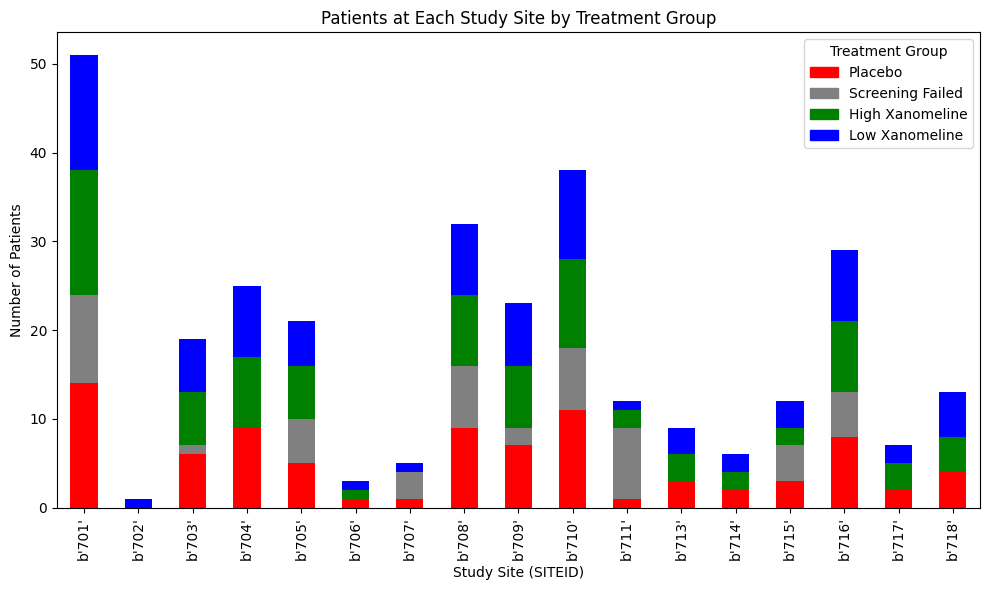

In [231]:
# plot patients per site
import matplotlib.pyplot as plt

# Group by site (SITEID) and assigned treatment (ARMCD), and count
site_treatment_counts = dm_data.groupby(['SITEID', 'ARMCD']).size().unstack(fill_value=0)

# Define colors
treatment_colors = {
    b'Xan_Lo': ['blue', 'Low Xanomeline'],   # Low Xanomeline
    b'Xan_Hi': ['green', 'High Xanomeline'],  # High Xanomeline
    b'Pbo': ['red', 'Placebo'],       # Placebo
    b'Scrnfail': ['gray', 'Screening Failed']  # Screening failed
}

# Stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))
site_treatment_counts.plot(kind='bar', stacked=True, color=[treatment_colors.get(x)[0] for x in site_treatment_counts.columns], ax=ax)

# Tidy
ax.set_title('Patients at Each Study Site by Treatment Group')
ax.set_xlabel('Study Site (SITEID)')
ax.set_ylabel('Number of Patients')

# Legend
handles = [plt.Rectangle((0,0),1,1, color=treatment_colors[treatment][0]) for treatment in site_treatment_counts.columns]
labels = [treatment_colors[treatment][1] for treatment in site_treatment_counts.columns]
ax.legend(handles, labels, title='Treatment Group')
plt.tight_layout()
plt.show()

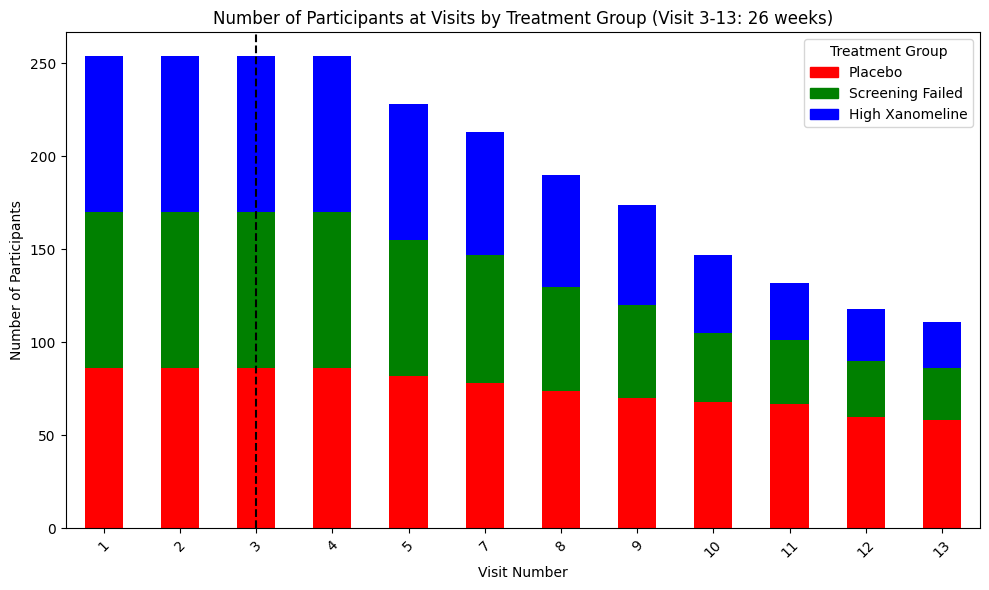

In [232]:
# Plot # of patients at each visit
sv_data = data_dict['sv.xpt'] # Subject visit

# Merge with demographic, to get treatment arm (ARMCD)
merged_data = pd.merge(sv_data, dm_data[['USUBJID', 'ARMCD']], on='USUBJID', how='left')

# Only look at these visit numbers
visitnums_of_interest = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]
filtered_data = merged_data[merged_data['VISITNUM'].isin(visitnums_of_interest)]
filtered_data = filtered_data[filtered_data['ARMCD'] != b'Scrnfail']

# Group by visit and arm, and count unique patients
visit_treatment_counts = filtered_data.groupby(['VISITNUM', 'ARMCD'])['USUBJID'].nunique().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar plot
visit_treatment_counts.plot(kind='bar', stacked=True, color=[treatment_colors.get(x)[0] for x in visit_treatment_counts.columns], ax=ax)

# Dotted line, represent treatment start after visit 3
ax.axvline(x=2, color='black', linestyle='--', linewidth=1.5, label='Treatment Start')

# Tidy
ax.set_title('Number of Participants at Visits by Treatment Group (Visit 3-13: 26 weeks)')
ax.set_xlabel('Visit Number')
ax.set_ylabel('Number of Participants')
ax.set_xticklabels(visitnums_of_interest, rotation=45)

# Legend
handles = [plt.Rectangle((0,0),1,1, color=treatment_colors[treatment][0]) for treatment in visit_treatment_counts.columns]
labels = [treatment_colors[treatment][1] for treatment in site_treatment_counts.columns]
ax.legend(handles, labels, title='Treatment Group')
plt.tight_layout()
plt.show()

# Very clear that patients in treatment groups are leaving the study more often than patients in the placebo group
# One could look at this further, e.g. with survival analysis (Kaplan Meier and Cox proportional hazard model). I will not do that though


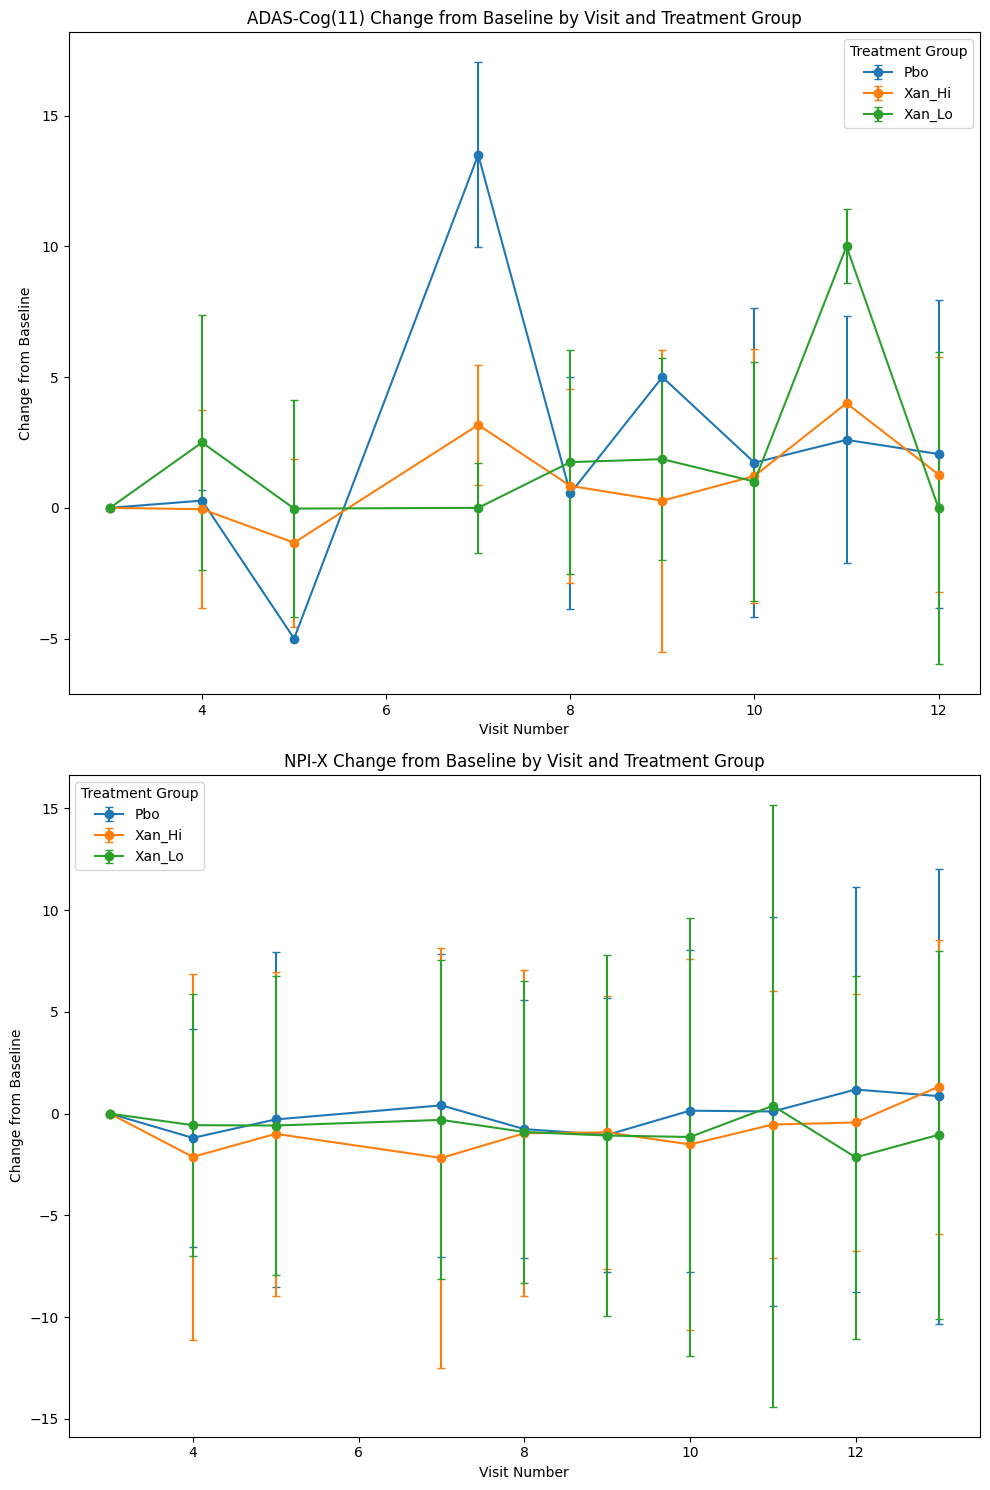

In [233]:
import pandas as pd
import matplotlib.pyplot as plt

# Get Questionnaires and demographic
qs_data = data_dict['qs.xpt']
dm_data = data_dict['dm.xpt']

# Merge data to get treatment arm
merged_data = pd.merge(qs_data, dm_data[['USUBJID', 'ARMCD']], on='USUBJID', how='left')

# Filter based on visits of interest (including baseline, which is visit 3)
visitnums_of_interest = [3, 4, 5, 7, 8, 9, 10, 11, 12, 13]
filtered_data = merged_data[merged_data['VISITNUM'].isin(visitnums_of_interest)]

# Define tests to look at, and name for figures
test_codes = {
    'ADAS-Cog(11)': b'ACTOT',
    'NPI-X': b'NPTOT'
}

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 15))

for i, (test_name, test_code) in enumerate(test_codes.items()):

    # Filter data for specific test
    test_data = filtered_data[filtered_data['QSTESTCD'] == test_code]

    # Get baseline data (Visit 3)
    baseline_data = test_data[test_data['VISITNUM'] == 3][['USUBJID', 'QSSTRESN']].set_index('USUBJID')
    baseline_data = baseline_data.rename(columns={'QSSTRESN': 'Baseline'})

    # Merge baseline with the test data on 'USUBJID'
    test_data = test_data.merge(baseline_data, on='USUBJID', how='left')

    # Calculate change from baseline
    test_data['Change_from_Baseline'] = test_data['QSSTRESN'] - test_data['Baseline']

    # Group by visit and treatment arm, and calculate mean change scores
    for treatment_group, group_data in test_data.groupby('ARMCD'):
        group_stats = group_data.groupby('VISITNUM')['Change_from_Baseline'].agg(
            mean_change='mean',
            std_dev='std',
            count='count'
        )


        # Plot mean change and error bars
        axes[i].errorbar(
            group_stats.index, group_stats['mean_change'], yerr=group_stats['std_dev'],
            label=treatment_group.decode('utf-8'), capsize=3, marker='o'
        )


    # Tidy
    axes[i].set_title(f'{test_name} Change from Baseline by Visit and Treatment Group')
    axes[i].set_xlabel('Visit Number')
    axes[i].set_ylabel('Change from Baseline')
    axes[i].legend(title='Treatment Group')


plt.tight_layout()
plt.show()


In [234]:
def summarize_adverse_events(demographics, adverse_events, list_of_adverse_events, treatment_group=None):

    # Merge data based on id (USUBJID)
    ae_data_merged = pd.merge(adverse_events, demographics[['USUBJID', 'ARMCD']], on='USUBJID', how='left')

    # Filter data by treatment group if specified
    if treatment_group:
        group_data = ae_data_merged[ae_data_merged['ARMCD'] == treatment_group]
        total_patients = np.sum(demographics['ARMCD'] == treatment_group)
    else:
        # For the overall summary, exclude 'Scrnfail'
        group_data = ae_data_merged[ae_data_merged['ARMCD'] != b'Scrnfail']
        total_patients = np.sum(demographics['ARMCD'] != b'Scrnfail')

    # Initialize a dictionary to store the results
    summary_dict = {'Adverse Event': [], 'Count': []}

    # Loop adverse events
    for ae in list_of_adverse_events:

        # Number of patients reporting specific ae
        ae_count = group_data[group_data['AEDECOD'] == ae]['USUBJID'].nunique()

        # In percentage
        percentage = (ae_count / total_patients) * 100 if total_patients > 0 else 0

        # Store results
        summary_dict['Adverse Event'].append(ae.decode('utf-8') )
        summary_dict['Count'].append(f'{ae_count} ({percentage:.1f}%)')

    # Convert the dictionary to a DataFrame
    summary_df = pd.DataFrame(summary_dict)

    return summary_df, total_patients



In [235]:
# Look at reported adverse event

ae_data = data_dict['ae.xpt']
dm_data = data_dict['dm.xpt']

# Count reported AEs
ae_counts = ae_data['AEDECOD'].value_counts()

# Get top 10 AEs
top_10_ae = list(ae_counts.index[:10])

# Get counts and percentages
low_xanomeline_summary, low_n = summarize_adverse_events(dm_data, ae_data, top_10_ae, treatment_group=b'Xan_Lo')
high_xanomeline_summary, high_n = summarize_adverse_events(dm_data, ae_data, top_10_ae, treatment_group=b'Xan_Hi')
placebo_summary, placebo_n = summarize_adverse_events(dm_data, ae_data, top_10_ae, treatment_group=b'Pbo')

overall_summary, overall_n = summarize_adverse_events(dm_data, ae_data, top_10_ae, treatment_group=None)

# Combine data
final_summary = pd.DataFrame({
    'Adverse Event': low_xanomeline_summary['Adverse Event'],
    f'High Xanomeline (n={high_n})': high_xanomeline_summary['Count'],
    f'Low Xanomeline (n={low_n})': low_xanomeline_summary['Count'],
    f'Placebo (n={placebo_n})': placebo_summary['Count'],
    f'Overall (n={overall_n})': overall_summary['Count']
})

# Display table
styled_summary = final_summary.style.format({
    'Low Xanomeline': '{:}',
    'High Xanomeline': '{:}',
    'Placebo': '{:}',
    'Overall': '{:}'
}).set_caption("Safety").set_table_styles([
    {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('color', 'black')]}
])

styled_summary


,Adverse Event,High Xanomeline (n=84),Low Xanomeline (n=84),Placebo (n=86),Overall (n=254)
0,PRURITUS,26 (31.0%),23 (27.4%),8 (9.3%),57 (22.4%)
1,APPLICATION SITE PRURITUS,22 (26.2%),22 (26.2%),6 (7.0%),50 (19.7%)
2,ERYTHEMA,14 (16.7%),15 (17.9%),9 (10.5%),38 (15.0%)
3,APPLICATION SITE ERYTHEMA,15 (17.9%),12 (14.3%),3 (3.5%),30 (11.8%)
4,RASH,11 (13.1%),13 (15.5%),5 (5.8%),29 (11.4%)
5,APPLICATION SITE IRRITATION,9 (10.7%),9 (10.7%),3 (3.5%),21 (8.3%)
6,APPLICATION SITE DERMATITIS,7 (8.3%),9 (10.7%),5 (5.8%),21 (8.3%)
7,DIZZINESS,12 (14.3%),8 (9.5%),2 (2.3%),22 (8.7%)
8,SKIN IRRITATION,5 (6.0%),6 (7.1%),3 (3.5%),14 (5.5%)
9,SINUS BRADYCARDIA,8 (9.5%),7 (8.3%),2 (2.3%),17 (6.7%)
